<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_Animation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM Animation (v1)
First experiments in animating the agent moving around a floorplan and using its model to perform SLAM.

Here I'm just focused on the preliminary utils I need to extract a trajectory from an image.

In [14]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout be28234
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam_models
import slam_motion
import slam_motion_test
import slam_data
import slam_data_test
from importlib import reload
reload(lds)
reload(slam_models)
reload(slam_motion)
reload(slam_motion_test)
reload(slam_data)
reload(slam_data_test)

slam_motion_test.run_test_suite()

HEAD is now at 42222c8 Bug fixes
Already up to date.


In [3]:
!pip install -Uqq ipdb

from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import imageio
import PIL
from IPython.display import clear_output, Image
from google.colab.patches import cv2_imshow
import requests
import math
import ipdb
import tqdm
import time
import gc
import datetime
from timeit import default_timer as timer

In [6]:
# Load floorplan
#floorplan = Image.open('repo/data/experimental-floorplan2-with-trajectory.png')
#floorplan = np.array(floorplan, dtype=np.uint8)
#print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255


## Extract trajectory from floorplan

array([[[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       ...,

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [  0,   0,   0],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]]], dtype=uint8)
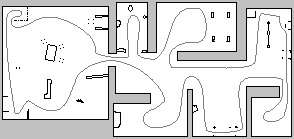

In [19]:
# Load the image
image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')
image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
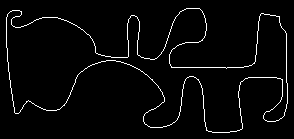

In [20]:
# Load the image
image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')

# Define the color range for the path (replace with actual BGR values)
lower_bound = np.array([127, 127, 127])  # lower BGR bound of the path color
upper_bound = np.array([128, 128, 128])  # upper BGR bound of the path color

# Create a mask to isolate the path based on the color range
mask = cv2.inRange(image, lower_bound, upper_bound)
mask

In [3]:
# Load the image
image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')

# Define the color range for the path (replace with actual BGR values)
lower_bound = np.array([127, 127, 127])  # lower BGR bound of the path color
upper_bound = np.array([128, 128, 128])  # upper BGR bound of the path color

# Create a mask to isolate the path based on the color range
mask = cv2.inRange(image, lower_bound, upper_bound)

# Find contours of the path
# - use CHAIN_APPROX_NONE in order to get coords for every pixel
contours, other = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(f"contours: {type(contours)} x {len(contours)}")
print(f"contours[0]: {type(contours[0])} x {contours[0].shape}")
print(f"other: {type(other)} x {len(other)}: {other}")

# I think it's a tuple containing one entry for each counter
# Then for each counter we have: (max_len, ?=1, (x,y))

contours: <class 'tuple'> x 1
contours[0]: <class 'numpy.ndarray'> x (1286, 1, 2)
other: <class 'numpy.ndarray'> x 1: [[[-1 -1 -1 -1]]]


In [22]:
# path_coords now holds the (x, y) coordinates along the path
path_coords = contours[0][:,0,:]
print(path_coords)


[[186   8]
 [185   9]
 [184   9]
 ...
 [189   8]
 [188   8]
 [187   8]]


array([[[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       ...,

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [  0,   0,   0],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]],

       [[192, 192, 192],
        [192, 192, 192],
        [192, 192, 192],
        ...,
        [192, 192, 192],
        [192, 192, 192],
        [192, 192, 192]]], dtype=uint8)
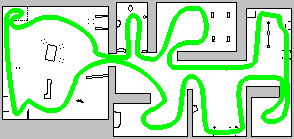

In [26]:
image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')
cv2.drawContours(image, [contours[0]], 0, (0,255,0), 3)

In [ ]:
## DON'T EXECUTE THIS CELL.
# Instead of animating, it generates a whole bunch of images in a long chain.

# # Load the image dimensions to create a blank canvas
# original_image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')
# height, width, _ = original_image.shape

# # Create a blank canvas to draw the animation
# canvas = np.zeros((height, width, 3), dtype=np.uint8)

# # Parameters for animation
# segment_length = 10  # Number of points per segment to draw
# delay = 50  # Delay in milliseconds between frames

# # Draw the contour in segments
# path = contours[0][:,0,:]
# for i in range(0, path.shape[0], segment_length):
#     segment = path[i:i + segment_length]

#     # Draw the segment on the canvas
#     for point in segment:
#         cv2.circle(canvas, point, radius=1, color=(0, 255, 0), thickness=-1)  # Green path

#     # Display the current frame
#     cv2_imshow(canvas)  # note: using google_colab patched version of cv2.imshow()

#     # Wait for a specified delay
#     if cv2.waitKey(delay) & 0xFF == ord('q'):  # Press 'q' to stop
#         break

# # Clean up
# cv2.destroyAllWindows()


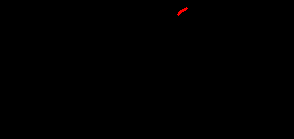

In [25]:
# Generates a GIF file of 7.5K.

# Load the image dimensions to create a blank canvas
original_image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')
height, width, _ = original_image.shape

# Create a blank canvas
canvas = np.zeros((height, width, 3), dtype=np.uint8)

# Parameters
segment_length = 10  # Number of points per segment
frames = []  # List to store frames for GIF

# Draw the contour in segments and capture frames
path = contours[0][:,0,:]
prev_segment = None
for i in range(0, path.shape[0], segment_length):
    segment = path[i:i + segment_length]

    # Colour the old segment green
    if prev_segment is not None:
        for point in prev_segment:
            cv2.circle(canvas, point, radius=1, color=(0, 255, 0), thickness=-1)  # Green path

    # Draw the new segment on the canvas in red
    for point in segment:
        cv2.circle(canvas, point, radius=1, color=(0, 0, 255), thickness=-1)  # Green path
    prev_segment = segment

    # Convert to RGB and add to frames list for GIF
    frame_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)

# Save the frames as a GIF
imageio.mimsave("path_animation.gif", frames, duration=0.05)  # Adjust duration as needed

# Display the GIF in the notebook
Image(filename="path_animation.gif")


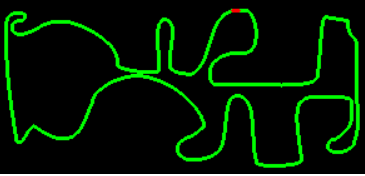

In [15]:
# Generates an MP4 file, of size 214KB

# Load the image dimensions to create a blank canvas
original_image = cv2.imread('repo/data/experimental-floorplan2-with-trajectory.png')
height, width, _ = original_image.shape

# Create a blank canvas
canvas = np.zeros((height, width, 3), dtype=np.uint8)

# Parameters
segment_length = 10  # Number of points per segment
fps = 20  # Frames per second for the video

# Define the video writer
video_path = "path_animation.mp4"
print(f"video_path: {video_path}")
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

# Draw the contour in segments and capture frames
path = contours[0][:,0,:]
for i in range(0, path.shape[0], segment_length):
    segment = path[i:i + segment_length]

    # Draw the segment on the canvas
    for point in segment:
        cv2.circle(canvas, point, radius=1, color=(0, 255, 0), thickness=-1)  # Green path

    # Write the frame to the video
    video_writer.write(canvas)

# Release the video writer
video_writer.release()

# Display the MP4 in the notebook
from IPython.display import Video
#Video(filename=video_path, embed=True)
Video(video_path, embed=True)


video_path: path_animation.mp4


## Formalise

**TODO**:
* I think I'll create a single "load_floorplan()" function, with a plural mirror of "load_floorplan_data()", that returns a `namedtuple (map, trajectory)`.

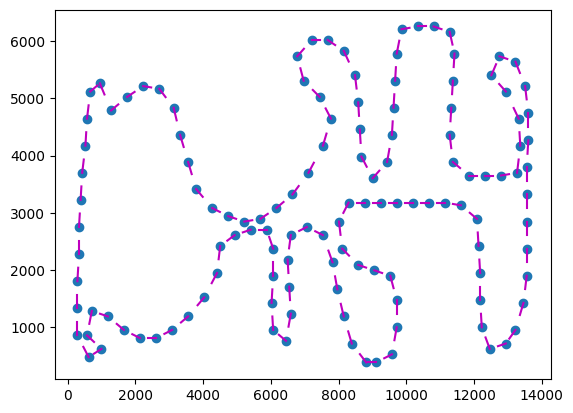

In [47]:
contour = slam_motion.get_contour_pxcoords('repo/data/experimental-floorplan2-with-trajectory.png')
coords, angles = slam_motion.sample_trajectory(contour)
print(f"coords: {coords.shape}")
print(f"angles: {angles.shape}")

plt.scatter(coords[:,0], coords[:,1])
for i in range(coords.shape[0]):
  angle = angles[i]
  loc1 = coords[i,:]
  loc2 = loc1 + np.array([np.cos(angle), np.sin(angle)]) * 5 * lds.__PIXEL_SIZE__
  plt.plot([loc1[0], loc2[0]], [loc1[1], loc2[1]], 'm-')
plt.show()

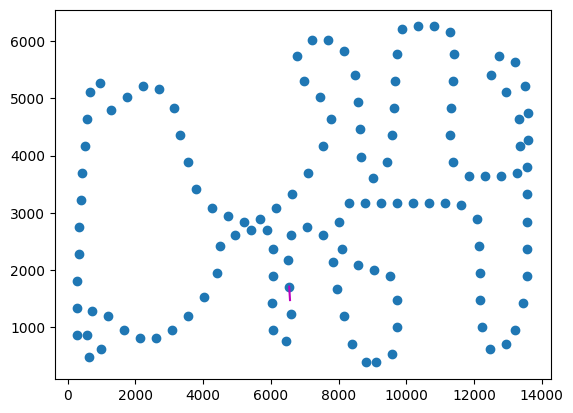

In [96]:
contour = slam_motion.get_contour_pxcoords('repo/data/experimental-floorplan2-with-trajectory.png')
coords, angles = slam_motion.sample_trajectory(contour)

#for i in range(coords.shape[0]):
for i in range(10):
  clear_output(wait=True)
  plt.scatter(coords[:,0], coords[:,1])
  angle = angles[i]
  loc1 = coords[i,:]
  loc2 = loc1 + np.array([np.cos(angle), np.sin(angle)]) * 5 * lds.__PIXEL_SIZE__
  plt.plot([loc1[0], loc2[0]], [loc1[1], loc2[1]], 'm-')
  plt.show()
  time.sleep(1)

## Animate moving around

In [4]:
# TODO update one_hot_encode_floorplan() so that it can remove the trajectory before encoding

# Load floorplan
floorplan = PIL.Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")
floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


In [5]:
# Load model
model = tf.keras.models.load_model('slam-model1-200epochs.keras')
print(f"Model loaded:")
print(f"  Inputs:           {model.inputs}")
print(f"  Outputs:          {model.outputs}")
print(f"  Layers:           {len(model.layers)}")

Model loaded:
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_122>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_124>]
  Layers:           60


pred state: +[-12.904583   9.458269] @ +-0.012626840732991695 = [6409.62688358 1806.0596664 ] @ -1.593611338495994 radians


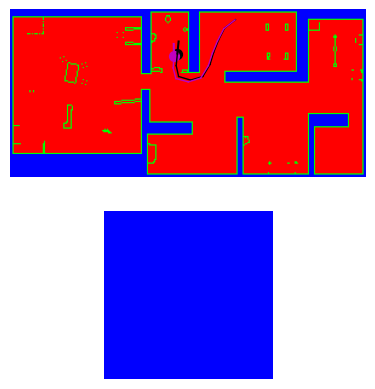

In [28]:
def show_single_prediction(map_pred, accept, delta_location, delta_orientation):
  print(f"Result:")
  print(f"  accept: {accept}")
  print(f"  delta_location: {delta_location / lds.__PIXEL_SIZE__} px")
  print(f"  delta_orientation: {np.rad2deg(delta_orientation)} degrees")

  # show adlo relative to centre dot
  centre = tf.gather(tf.shape(map_pred), (1,0)) / 2
  error_loc = centre + delta_location / lds.__PIXEL_SIZE__
  angle_loc = error_loc + np.array([np.cos(delta_orientation), np.sin(delta_orientation)]) * 10

  plt.imshow(map_pred)
  plt.axis('off')
  plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
  plt.scatter(centre[0], centre[1], c='k', s=50)
  plt.scatter(error_loc[0], error_loc[1], c='m', s=50)
  plt.show()

def show_state_against_truth(floorplan, true_location, true_angle, true_trajectory, pred_accept, pred_location, pred_orientation, pred_trajectory):
  true_loc = true_location / lds.__PIXEL_SIZE__
  true_angle_loc = true_loc + np.array([np.cos(true_angle), np.sin(true_angle)]) * 10

  pred_loc = pred_location / lds.__PIXEL_SIZE__
  pred_angle_loc = pred_loc + np.array([np.cos(pred_orientation), np.sin(pred_orientation)]) * 10

  plt.imshow(floorplan)
  plt.axis('off')

  def plot_trajectory(trajectory, c):
    trajectory = np.array(trajectory) / lds.__PIXEL_SIZE__
    for i in range(trajectory.shape[0]-1):
      plt.plot(trajectory[i:i+2,0], trajectory[i:i+2,1], c=c, linewidth=1)
  plot_trajectory(true_trajectory, 'k')
  plot_trajectory(pred_trajectory, 'm')

  plt.scatter(true_loc[0], true_loc[1], c='k', s=50)
  plt.plot([true_loc[0], true_angle_loc[0]], [true_loc[1], true_angle_loc[1]], c='k')
  plt.scatter(pred_loc[0], pred_loc[1], c='m', s=50)
  plt.plot([pred_loc[0], pred_angle_loc[0]], [pred_loc[1], pred_angle_loc[1]], c='m')

  # todo show accept
  #plt.plot([0, map_size[0]-1], [0, map_size[1]-1], c='y', alpha=1-adlo_pred_scaled[0].numpy())
  #plt.plot([0, map_size[0]-1], [map_size[1]-1, 0], c='y', alpha=1-adlo_pred_scaled[0].numpy())

def show_state_against_prediction(known_map, known_map_start):
  plt.imshow(known_map)
  plt.axis('off')

reload(slam_motion)
reload(slam_data)
reload(lds)

# Get trajectory
contour = slam_motion.get_contour_pxcoords('repo/data/experimental-floorplan2-with-trajectory.png')
trajectory_coords, trajectory_angles = slam_motion.sample_trajectory(contour)

# initial map is unknown and centred on the starting position
known_map = slam_data.unknown_map((149, 149))
known_map_start = trajectory_coords[0] - lds.__MAX_DISTANCE__

# Mave through trajectory
true_trajectory = []
pred_trajectory = []
prev_true_location = trajectory_coords[0]
prev_true_angle = trajectory_angles[0]
current_pred_location = prev_true_location.copy()
current_pred_angle = prev_true_angle.copy()
for i in range(0, 5):
  # move agent
  true_location = trajectory_coords[i]
  true_angle = trajectory_angles[i]
  true_location_movement = true_location - prev_true_location
  true_angle_movement = true_angle - prev_true_angle
  prev_true_location = true_location
  prev_true_angle = true_angle
  print(f"true state: +{true_location_movement} @ +{true_angle_movement} = {true_location} @ {true_angle} radians   <-- {type(true_location)}")

  # update estimated state from movement
  current_pred_location += true_location_movement
  current_pred_angle += true_angle_movement
  print(f"est. state: +{true_location_movement} @ +{true_angle_movement} = {current_pred_location} @ {current_pred_angle} radians")

  # do prediction
  (map_pred, accept, delta_location, delta_orientation) = slam_motion.predict_at_location(floorplan, known_map, known_map_start, model, true_location, true_angle)
  clear_output(wait=True)

  # revise estimated state from prediction
  current_pred_location += delta_location  # (note: does in-place update)
  current_pred_angle += delta_orientation  # (note: does in-place update)
  print(f"pred state: +{delta_location} @ +{delta_orientation} = {current_pred_location} @ {current_pred_angle} radians")

  true_trajectory.append(true_location)
  pred_trajectory.append(current_pred_location.copy())

  plt.subplot(2,1,1)
  show_state_against_truth(floorplan, true_location, true_angle, true_trajectory, accept, current_pred_location, current_pred_angle, pred_trajectory)
  #show_single_prediction(map_pred, accept, delta_location, delta_orientation)
  plt.subplot(2,1,2)
  show_state_against_prediction(known_map, known_map_start)
  plt.show()
  time.sleep(1)


In [120]:
a = np.array([[1,2],[3,4],[5,6],[7,8]])
a[1:3]

array([[3, 4],
       [5, 6]])

## Appendix: Prove out basic steps

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
Result:
  map_pred: <class 'tensorflow.python.framework.ops.EagerTensor'> = (149, 149, 3) x <dtype: 'float32'>
  accept: <class 'numpy.bool_'> = True
  delta_location: <class 'numpy.ndarray'> = (2,) x float32 = [-0.55805033  0.01094749] px
  delta_orientation: <class 'numpy.float32'> = -0.02030164748430252 degrees


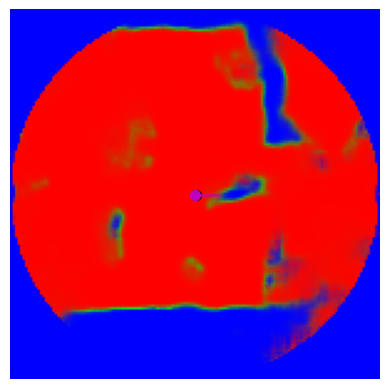

In [84]:
reload(slam_data)
reload(slam_motion)

contour = slam_motion.get_contour_pxcoords('repo/data/experimental-floorplan2-with-trajectory.png')
trajectory_coords, trajectory_angles = slam_motion.sample_trajectory(contour)
true_location = trajectory_coords[50]
true_angle = trajectory_angles[50]

# initial map is unknown
known_map = slam_data.unknown_map((149, 149))
known_map_start = true_location - lds.__MAX_DISTANCE__

# do prediction
(map_pred, accept, delta_location, delta_orientation) = slam_motion.predict_at_location(floorplan, known_map, known_map_start, model, true_location, true_angle)
print(f"Result:")
print(f"  map_pred: {type(map_pred)} = {map_pred.shape} x {map_pred.dtype}")
print(f"  accept: {type(accept)} = {accept}")
print(f"  delta_location: {type(delta_location)} = {delta_location.shape} x {delta_location.dtype} = {delta_location / lds.__PIXEL_SIZE__} px")
print(f"  delta_orientation: {type(delta_orientation)} = {np.rad2deg(delta_orientation)} degrees")

# show adlo relative to centre dot
centre = tf.gather(tf.shape(map_pred), (1,0)) / 2
error_loc = centre + delta_location / lds.__PIXEL_SIZE__
angle_loc = error_loc + np.array([np.cos(delta_orientation), np.sin(delta_orientation)]) * 10

plt.imshow(map_pred)
plt.axis('off')
plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
plt.scatter(centre[0], centre[1], c='k', s=50)
plt.scatter(error_loc[0], error_loc[1], c='m', s=50)

plt.show()